## theory

$$
\psi (y) = \int dy' G(y, y') \frac{u''(y')}{u(y) - ic_j} \psi(y')
$$

where 
$y$ — coordinate from $-a$ to $a$ \
$c_j$ — imaginary part of phase velocity and its real part is equal to zero \
$u (y)$ — velocity \
$\psi (y)$ — stream function \
$G(y, y')$ — Green function \

We can find $\psi (y)$ by reducing the problem to solving the set of eigenequations:

1) We build new equation
$$
\lambda \psi (y) = \int dy' G(y, y') \frac{u''(y')}{u - ic_j} \psi(y')
$$

2) We search for those value of $c_j$ such that $\lambda = 1$.
3) Stream function $\psi (y)$ will be the eigenvector that corresponds to eigenvalue $\lambda = 1$ and phase velocity $c_j$

However, there is a pole at the point where $u(y) = ic_j$, so we need to add residue using the Landau Contour

## imports

In [1]:
import numpy as np
from numpy import linalg as l
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tqdm import tqdm

## functions

In [2]:
def initial_state(a):
    uy = np.linspace(-np.sqrt(a), np.sqrt(a), 1001)
    y = np.sign(uy) * uy ** 2
    c = np.linspace(-0.05, 0.05, 20)

    Y, Y_ = np.meshgrid(y, y, indexing='ij')

    step_y1 = y - np.roll(y, 1)
    step_y2 = np.roll(y, -1) - y
    step_y1[0] = step_y2[-1] = 0
    step_y = (step_y1 + step_y2) / 2 #trapezoidal rule

    u = np.tanh(y)
    dev2u = - 2 * np.tanh(y) / (np.cosh(y) ** 2)

    min_Y = np.minimum(Y, Y_)
    max_Y = np.maximum(Y, Y_)

    return y, c, u, dev2u, step_y, min_Y, max_Y

In [3]:
def count_eigen(k, a, c, max_Y, u, min_Y, dev2u, step_y):
    eps = 1e-15
    green = - (np.exp(- k * max_Y) - np.exp(- k * (2 * a - max_Y))) * \
              (np.exp(k * min_Y) - np.exp(- k * (2 * a + min_Y))) / \
              (1 - np.exp(- 4 * k * a)) / 2 / k
    
    residue = np.zeros_like(green, dtype=np.complex128)
    residue[:, len(u) // 2 + 1] = (4 * np.pi * c *
                                   green[:, len(u) // 2 + 1])
    
    kernel =  dev2u * green * step_y / (u - 1j * c + eps) 
    
    if (c < 0):
        kernel += residue
        
    if c == 0:
        kernel += residue / 2
    
    val, vect = l.eig(kernel)
    return val, vect

In [4]:
def find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y):
    lambdas = []
    for i in range(len(c)):
        vals, vect= count_eigen(k, a, c[i], max_Y, u, min_Y, dev2u, step_y)
        lambdas.append(np.real(vals).max())
      
    return np.array(lambdas)

In [5]:
def find_c(lambdas):
    idx = np.abs(lambdas - 1).argmin()
    return c[idx]

In [6]:
def find_streamfunc(k, a, c0, max_Y, u, min_Y, dev2u, step_y):
    vals, vect = count_eigen(k, a, c0, max_Y, u, min_Y, dev2u, step_y)
    vect = vect.T
    return vect[np.real(vals).argmax()]

## initial state

In [7]:
a = 5

k_unstable = 0.9907
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
lambdas_unstable = find_lambdas(k_unstable, a, c, max_Y, u, min_Y, dev2u, step_y)

In [8]:
k_edge = 0.9997
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
lambdas_edge = find_lambdas(k_edge, a, c, max_Y, u, min_Y, dev2u, step_y)

In [9]:
k_stable = 1.0087
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
lambdas_stable = find_lambdas(k_stable, a, c, max_Y, u, min_Y, dev2u, step_y)

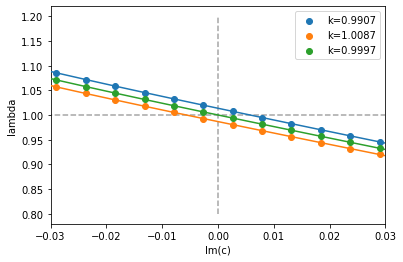

In [10]:
plt.plot([c.min(), c.max()], [1, 1], ls='--', c='grey', alpha=0.7)
plt.plot([0, 0], [0.8, 1.2], ls='--', c='grey', alpha=0.7)
plt.scatter(c, lambdas_unstable, label=f'k={k_unstable}', zorder=100)
plt.plot(c, lambdas_unstable, zorder=101)

plt.scatter(c, lambdas_stable, label=f'k={k_stable}', zorder=100)
plt.plot(c, lambdas_stable, zorder=101)

plt.scatter(c, lambdas_edge, label=f'k={k_edge}', zorder=100)
plt.plot(c, lambdas_edge, zorder=101)

plt.xlabel('Im(c)')
plt.ylabel('lambda')
plt.xlim(-0.03, 0.03)
plt.legend()

In [11]:
c_array = []
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
k_array = np.linspace(0.9, 1.1, 50)
for k in tqdm(k_array):
    lambdas = find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y)
    c_0 = find_c(lambdas)
    c_array.append(c_0)

100%|██████████| 50/50 [34:00<00:00, 40.80s/it]


Text(0, 0.5, 'Im(c)')

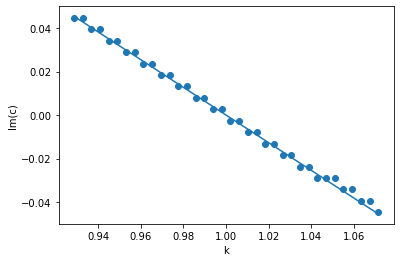

In [12]:
plt.scatter(k_array[7:-7], c_array[7:-7])
plt.plot(k_array[7:-7], (1 - k_array[7:-7]) * 2 / np.pi)
plt.xlabel('k')
plt.ylabel('Im(c)')

In [13]:
c0_unstable = find_c(lambdas_unstable)
c0_stable = find_c(lambdas_stable)
c0_edge = find_c(lambdas_edge)

In [14]:
streamfunc_unstable = find_streamfunc(k, a, c0_unstable, max_Y, u, min_Y, dev2u, step_y)
streamfunc_stable = find_streamfunc(k, a, c0_stable, max_Y, u, min_Y, dev2u, step_y)
streamfunc_edge = find_streamfunc(k, a, c0_edge, max_Y, u, min_Y, dev2u, step_y)

Text(0, 0.5, 'psi(y)')

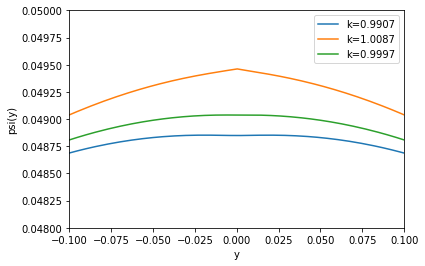

In [17]:
plt.plot(y, np.real(streamfunc_unstable), label=f'k={k_unstable}')
plt.plot(y, np.real(streamfunc_stable), label=f'k={k_stable}')
plt.plot(y, np.real(streamfunc_edge), label=f'k={k_edge}')
plt.legend()
plt.xlim(-0.1,0.1)
plt.ylim(0.048,0.05)
plt.xlabel('y')
plt.ylabel('psi(y)')